<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE9-WEEK3/m09w03_project_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data và mô hình

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# khai báo siêu tham số và các Hyperparameters
batch_size = 256
img_size = 28
channels = 1
latent_dim = 2
num_epochs = 500

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

# download MNIST data
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.64MB/s]


In [4]:
# chia dữ liệu thành 2 phần, 80% cho việc kiểm tra và 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Train size: {train_size}, Val size: {val_size}")

Train size: 48000, Val size: 12000


In [5]:
# creat DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
# prompt: định nghĩa một class VAE với pytorch, encoder, decoder với kernel_size =3, padding =1, stride =2

class VAE(nn.Module):
    def __init__(self, img_channels=1, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(img_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.convT1 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.convT2 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv_final = nn.Conv2d(16, img_channels, kernel_size=3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 64, 7, 7)  # Reshape
        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [7]:
# prompt: định nghĩa hàm mất mát của VAE

def vae_loss(x_recon, x, mu, logvar, B=1000):
  """
  Hàm tính toán hàm mất mát của VAE.

  Args:
    x_recon: Ảnh được tái tạo bởi decoder.
    x: Ảnh gốc.
    mu: Trung bình của phân phối hậu nghiệm.
    logvar: Log-variance của phân phối hậu nghiệm.

  Returns:
    Hàm mất mát.
  """
  # Flatten tensors for MSE calculation
  recon_x_flat = x_recon.view(x_recon.size(0), -1)
  x_flat = x.view(x.size(0), -1)

  # Calculate MSE (per element average)
  mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')

  # Scale by input dimensions
  # Tổng MSE trên mỗi ảnh
  # Nhưng vẫn chia trung bình theo batch
  reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

  # Calculate KL divergence
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=1)

  # Compute final loss (adding B*recon_loss + kl_loss)
  total_loss = B * reconstruction_loss + torch.mean(kl_loss)

  return total_loss, reconstruction_loss, torch.mean(kl_loss)


In [8]:
model = VAE(img_channels=channels, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
import os
from datetime import datetime

# Create a log directory if it doesn’t exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total epochs: {num_epochs}\n")
    f.write(f"Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

# Training loop with logging
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        epoch_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = train_loss / len(train_loader.dataset)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f} "
          f"Recon Loss: {recon_loss.item():.4f} KL Loss: {kl_loss.item():.4f}")

    # Save to log file
    with open(log_file, "a") as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n")

# Log training completion
with open(log_file, "a") as f:
    f.write(f"Training completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
print(f"Training log saved to {log_file}")


Epoch 1/500 Loss per sample: 308.5142 Recon Loss: 48.9841 KL Loss: 18.1750


Epoch 2/500 Loss per sample: 179.1470 Recon Loss: 44.0373 KL Loss: 21.4055


Epoch 3/500 Loss per sample: 162.4466 Recon Loss: 42.6639 KL Loss: 19.5109


Epoch 4/500 Loss per sample: 155.5649 Recon Loss: 38.8572 KL Loss: 20.1522


Epoch 5/500 Loss per sample: 151.1691 Recon Loss: 41.5875 KL Loss: 17.3170


Epoch 6/500 Loss per sample: 147.4878 Recon Loss: 33.9188 KL Loss: 19.0541


Epoch 7/500 Loss per sample: 144.4245 Recon Loss: 36.1806 KL Loss: 19.5758


Epoch 8/500 Loss per sample: 142.3357 Recon Loss: 33.2958 KL Loss: 20.0165


Epoch 9/500 Loss per sample: 140.5235 Recon Loss: 34.8326 KL Loss: 19.4938


Epoch 10/500 Loss per sample: 139.1208 Recon Loss: 35.3093 KL Loss: 19.1449


Epoch 11/500 Loss per sample: 137.9038 Recon Loss: 34.3673 KL Loss: 18.3503


Epoch 12/500 Loss per sample: 136.6992 Recon Loss: 34.5826 KL Loss: 19.0279


Epoch 13/500 Loss per sample: 135.8739 Recon Loss: 35.3996 KL Loss: 17.7695


Epoch 14/500 Loss per sample: 134.9588 Recon Loss: 34.4055 KL Loss: 19.2481


Epoch 15/500 Loss per sample: 134.0686 Recon Loss: 32.2475 KL Loss: 19.1306


Epoch 16/500 Loss per sample: 133.3587 Recon Loss: 35.2682 KL Loss: 17.7566


Epoch 17/500 Loss per sample: 132.7561 Recon Loss: 35.3575 KL Loss: 18.8222


Epoch 18/500 Loss per sample: 132.1162 Recon Loss: 33.5683 KL Loss: 17.8992


Epoch 19/500 Loss per sample: 131.6538 Recon Loss: 34.7333 KL Loss: 18.1920


Epoch 20/500 Loss per sample: 131.1901 Recon Loss: 34.9170 KL Loss: 17.7187


Epoch 21/500 Loss per sample: 130.7044 Recon Loss: 35.9949 KL Loss: 16.8901


Epoch 22/500 Loss per sample: 130.1098 Recon Loss: 34.2385 KL Loss: 19.0720


Epoch 23/500 Loss per sample: 129.7995 Recon Loss: 34.1067 KL Loss: 16.4004


Epoch 24/500 Loss per sample: 129.4229 Recon Loss: 33.7720 KL Loss: 17.2052


Epoch 25/500 Loss per sample: 128.9744 Recon Loss: 32.4757 KL Loss: 17.2714


Epoch 26/500 Loss per sample: 129.0351 Recon Loss: 33.1474 KL Loss: 17.7776


Epoch 27/500 Loss per sample: 128.3911 Recon Loss: 31.7695 KL Loss: 19.0840


Epoch 28/500 Loss per sample: 128.2113 Recon Loss: 34.4727 KL Loss: 18.6082


Epoch 29/500 Loss per sample: 127.7932 Recon Loss: 34.8625 KL Loss: 17.3062


Epoch 30/500 Loss per sample: 127.3970 Recon Loss: 34.3536 KL Loss: 18.5740


Epoch 31/500 Loss per sample: 127.3632 Recon Loss: 32.5987 KL Loss: 16.5701


Epoch 32/500 Loss per sample: 126.9563 Recon Loss: 29.8453 KL Loss: 19.3237


Epoch 33/500 Loss per sample: 126.6340 Recon Loss: 31.8644 KL Loss: 16.5167


Epoch 34/500 Loss per sample: 126.5972 Recon Loss: 33.1343 KL Loss: 17.2109


Epoch 35/500 Loss per sample: 126.2194 Recon Loss: 33.4945 KL Loss: 18.6692


Epoch 36/500 Loss per sample: 126.2181 Recon Loss: 32.7531 KL Loss: 18.3134


Epoch 37/500 Loss per sample: 125.7586 Recon Loss: 31.2370 KL Loss: 18.7931


Epoch 38/500 Loss per sample: 125.7457 Recon Loss: 32.0264 KL Loss: 19.2650


Epoch 39/500 Loss per sample: 125.3302 Recon Loss: 32.4609 KL Loss: 17.9708


Epoch 40/500 Loss per sample: 125.1669 Recon Loss: 31.2602 KL Loss: 16.9273


Epoch 41/500 Loss per sample: 124.9138 Recon Loss: 33.3911 KL Loss: 18.0004


Epoch 42/500 Loss per sample: 124.8610 Recon Loss: 32.4203 KL Loss: 16.6201


Epoch 43/500 Loss per sample: 124.7522 Recon Loss: 31.4197 KL Loss: 17.1049


Epoch 44/500 Loss per sample: 124.4203 Recon Loss: 33.1582 KL Loss: 16.5925


Epoch 45/500 Loss per sample: 124.3988 Recon Loss: 30.2326 KL Loss: 17.9648


Epoch 46/500 Loss per sample: 123.9932 Recon Loss: 28.7580 KL Loss: 18.7060


Epoch 47/500 Loss per sample: 123.9131 Recon Loss: 32.1949 KL Loss: 18.0689


Epoch 48/500 Loss per sample: 123.8642 Recon Loss: 30.5034 KL Loss: 19.0781


Epoch 49/500 Loss per sample: 123.7084 Recon Loss: 31.0070 KL Loss: 18.0009


Epoch 50/500 Loss per sample: 123.6297 Recon Loss: 34.2485 KL Loss: 17.7511


Epoch 51/500 Loss per sample: 123.5169 Recon Loss: 36.1110 KL Loss: 16.4285


Epoch 52/500 Loss per sample: 123.3960 Recon Loss: 30.7571 KL Loss: 17.2173


Epoch 53/500 Loss per sample: 123.0931 Recon Loss: 31.4676 KL Loss: 16.9561


Epoch 54/500 Loss per sample: 122.8679 Recon Loss: 30.9411 KL Loss: 18.5738


Epoch 55/500 Loss per sample: 122.9322 Recon Loss: 31.6972 KL Loss: 17.5743


Epoch 56/500 Loss per sample: 122.7092 Recon Loss: 31.2167 KL Loss: 17.0243


Epoch 57/500 Loss per sample: 122.6737 Recon Loss: 30.0982 KL Loss: 17.9934


Epoch 58/500 Loss per sample: 122.4961 Recon Loss: 29.7076 KL Loss: 17.9079


Epoch 59/500 Loss per sample: 122.3916 Recon Loss: 31.8434 KL Loss: 17.5329


Epoch 60/500 Loss per sample: 122.2835 Recon Loss: 31.8213 KL Loss: 17.5218


Epoch 61/500 Loss per sample: 122.2424 Recon Loss: 31.3054 KL Loss: 17.3923


Epoch 62/500 Loss per sample: 121.8457 Recon Loss: 30.5769 KL Loss: 19.0454


Epoch 63/500 Loss per sample: 122.2240 Recon Loss: 31.7401 KL Loss: 16.8746


Epoch 64/500 Loss per sample: 121.8504 Recon Loss: 29.2628 KL Loss: 17.7844


Epoch 65/500 Loss per sample: 121.7281 Recon Loss: 29.8160 KL Loss: 18.4581


Epoch 66/500 Loss per sample: 121.6870 Recon Loss: 34.2096 KL Loss: 17.7807


Epoch 67/500 Loss per sample: 121.4686 Recon Loss: 32.2856 KL Loss: 19.0956


Epoch 68/500 Loss per sample: 121.5286 Recon Loss: 32.9867 KL Loss: 15.9454


Epoch 69/500 Loss per sample: 121.2416 Recon Loss: 30.2357 KL Loss: 17.3104


Epoch 70/500 Loss per sample: 121.2252 Recon Loss: 31.8810 KL Loss: 17.5116


Epoch 71/500 Loss per sample: 121.1951 Recon Loss: 30.9663 KL Loss: 18.3093


Epoch 72/500 Loss per sample: 121.1197 Recon Loss: 27.2137 KL Loss: 19.0877


Epoch 73/500 Loss per sample: 120.9308 Recon Loss: 28.5355 KL Loss: 19.2030


Epoch 74/500 Loss per sample: 121.0932 Recon Loss: 30.3329 KL Loss: 19.3085


Epoch 75/500 Loss per sample: 120.8872 Recon Loss: 30.7035 KL Loss: 15.7641


Epoch 76/500 Loss per sample: 120.7767 Recon Loss: 28.7707 KL Loss: 18.8324


Epoch 77/500 Loss per sample: 120.6968 Recon Loss: 31.2844 KL Loss: 17.1759


Epoch 78/500 Loss per sample: 120.6494 Recon Loss: 30.8849 KL Loss: 17.2605


Epoch 79/500 Loss per sample: 120.4244 Recon Loss: 30.5724 KL Loss: 19.7437


Epoch 80/500 Loss per sample: 120.5892 Recon Loss: 31.7769 KL Loss: 17.4919


Epoch 81/500 Loss per sample: 120.3025 Recon Loss: 31.6236 KL Loss: 18.0695


Epoch 82/500 Loss per sample: 120.2903 Recon Loss: 27.5909 KL Loss: 19.0472


Epoch 83/500 Loss per sample: 120.3248 Recon Loss: 29.5975 KL Loss: 19.2809


Epoch 84/500 Loss per sample: 120.0694 Recon Loss: 30.4938 KL Loss: 17.7814


Epoch 85/500 Loss per sample: 120.1161 Recon Loss: 30.6823 KL Loss: 17.8544


Epoch 86/500 Loss per sample: 119.8916 Recon Loss: 31.0322 KL Loss: 18.6995


Epoch 87/500 Loss per sample: 119.9482 Recon Loss: 30.9457 KL Loss: 18.6106


Epoch 88/500 Loss per sample: 120.0155 Recon Loss: 29.6434 KL Loss: 19.3753


Epoch 89/500 Loss per sample: 119.7952 Recon Loss: 30.2221 KL Loss: 17.9394


Epoch 90/500 Loss per sample: 119.5920 Recon Loss: 29.9382 KL Loss: 18.8512


Epoch 91/500 Loss per sample: 119.7369 Recon Loss: 34.0089 KL Loss: 16.2660


Epoch 92/500 Loss per sample: 119.5287 Recon Loss: 29.4941 KL Loss: 20.2719


Epoch 93/500 Loss per sample: 119.6334 Recon Loss: 31.9599 KL Loss: 18.8085


Epoch 94/500 Loss per sample: 119.4144 Recon Loss: 29.5219 KL Loss: 17.0816


Epoch 95/500 Loss per sample: 119.4861 Recon Loss: 29.5715 KL Loss: 19.6083


Epoch 96/500 Loss per sample: 119.4387 Recon Loss: 27.7002 KL Loss: 18.8302


Epoch 97/500 Loss per sample: 119.3094 Recon Loss: 32.4003 KL Loss: 17.5699


Epoch 98/500 Loss per sample: 119.1683 Recon Loss: 31.8485 KL Loss: 18.4428


Epoch 99/500 Loss per sample: 119.0667 Recon Loss: 32.4245 KL Loss: 18.3895


Epoch 100/500 Loss per sample: 119.1499 Recon Loss: 32.5330 KL Loss: 16.1347


Epoch 101/500 Loss per sample: 119.1419 Recon Loss: 28.7195 KL Loss: 19.4181


Epoch 102/500 Loss per sample: 119.0138 Recon Loss: 32.0161 KL Loss: 16.8820


Epoch 103/500 Loss per sample: 119.0373 Recon Loss: 30.3095 KL Loss: 16.1692


Epoch 104/500 Loss per sample: 119.1193 Recon Loss: 31.3832 KL Loss: 17.3921


Epoch 105/500 Loss per sample: 118.9277 Recon Loss: 29.7063 KL Loss: 19.7581


Epoch 106/500 Loss per sample: 118.7004 Recon Loss: 31.2749 KL Loss: 17.6447


Epoch 107/500 Loss per sample: 118.6656 Recon Loss: 26.5063 KL Loss: 18.6553


Epoch 108/500 Loss per sample: 118.6466 Recon Loss: 30.3563 KL Loss: 18.3645


Epoch 109/500 Loss per sample: 118.6238 Recon Loss: 31.0721 KL Loss: 17.2735


Epoch 110/500 Loss per sample: 118.5858 Recon Loss: 30.0846 KL Loss: 18.1808


Epoch 111/500 Loss per sample: 118.5091 Recon Loss: 33.3649 KL Loss: 16.6290


Epoch 112/500 Loss per sample: 118.4911 Recon Loss: 30.1766 KL Loss: 20.1938


Epoch 113/500 Loss per sample: 118.3690 Recon Loss: 29.4917 KL Loss: 19.3993


Epoch 114/500 Loss per sample: 118.3135 Recon Loss: 29.5954 KL Loss: 17.3330


Epoch 115/500 Loss per sample: 118.4029 Recon Loss: 32.1843 KL Loss: 18.1265


Epoch 116/500 Loss per sample: 118.3391 Recon Loss: 29.4234 KL Loss: 19.3993


Epoch 117/500 Loss per sample: 118.2253 Recon Loss: 29.1671 KL Loss: 18.4032


Epoch 118/500 Loss per sample: 118.3525 Recon Loss: 28.6315 KL Loss: 19.3830


Epoch 119/500 Loss per sample: 118.1246 Recon Loss: 32.2878 KL Loss: 19.5248


Epoch 120/500 Loss per sample: 118.0316 Recon Loss: 30.9568 KL Loss: 19.7237


Epoch 121/500 Loss per sample: 118.0635 Recon Loss: 29.8116 KL Loss: 18.0015


Epoch 122/500 Loss per sample: 117.9653 Recon Loss: 29.2034 KL Loss: 18.2805


Epoch 123/500 Loss per sample: 118.0793 Recon Loss: 32.2290 KL Loss: 16.3963


Epoch 124/500 Loss per sample: 118.0843 Recon Loss: 32.0775 KL Loss: 18.6779


Epoch 125/500 Loss per sample: 117.9739 Recon Loss: 32.0500 KL Loss: 18.4159


Epoch 126/500 Loss per sample: 117.8517 Recon Loss: 30.8107 KL Loss: 18.7444


Epoch 127/500 Loss per sample: 117.8174 Recon Loss: 29.9255 KL Loss: 18.5761


Epoch 128/500 Loss per sample: 117.8595 Recon Loss: 26.5947 KL Loss: 18.9423


Epoch 129/500 Loss per sample: 117.7121 Recon Loss: 28.6576 KL Loss: 19.8208


Epoch 130/500 Loss per sample: 117.7124 Recon Loss: 30.6391 KL Loss: 20.4396


Epoch 131/500 Loss per sample: 117.5921 Recon Loss: 30.6684 KL Loss: 18.5426


Epoch 132/500 Loss per sample: 117.8106 Recon Loss: 30.7990 KL Loss: 18.7886


Epoch 133/500 Loss per sample: 117.5112 Recon Loss: 31.4965 KL Loss: 20.0699


Epoch 134/500 Loss per sample: 117.6079 Recon Loss: 29.8885 KL Loss: 19.7209


Epoch 135/500 Loss per sample: 117.4339 Recon Loss: 28.6867 KL Loss: 21.3845


Epoch 136/500 Loss per sample: 117.4757 Recon Loss: 30.4052 KL Loss: 18.0162


Epoch 137/500 Loss per sample: 117.5719 Recon Loss: 30.6938 KL Loss: 19.6254


Epoch 138/500 Loss per sample: 117.4763 Recon Loss: 30.6868 KL Loss: 20.0985


Epoch 139/500 Loss per sample: 117.3619 Recon Loss: 28.1039 KL Loss: 18.1757


Epoch 140/500 Loss per sample: 117.2825 Recon Loss: 29.6379 KL Loss: 19.9742


Epoch 141/500 Loss per sample: 117.3249 Recon Loss: 29.6048 KL Loss: 17.5866


Epoch 142/500 Loss per sample: 117.4148 Recon Loss: 28.9513 KL Loss: 19.0767


Epoch 143/500 Loss per sample: 117.2214 Recon Loss: 31.2066 KL Loss: 19.2249


Epoch 144/500 Loss per sample: 117.3327 Recon Loss: 30.5653 KL Loss: 21.1604


Epoch 145/500 Loss per sample: 117.1926 Recon Loss: 30.0470 KL Loss: 18.6633


Epoch 146/500 Loss per sample: 117.2055 Recon Loss: 31.8641 KL Loss: 17.7765


Epoch 147/500 Loss per sample: 117.1396 Recon Loss: 30.2760 KL Loss: 21.7980


Epoch 148/500 Loss per sample: 117.1080 Recon Loss: 31.0850 KL Loss: 20.6218


Epoch 149/500 Loss per sample: 117.1965 Recon Loss: 32.2782 KL Loss: 15.9973


Epoch 150/500 Loss per sample: 116.8939 Recon Loss: 30.6585 KL Loss: 18.4295


Epoch 151/500 Loss per sample: 116.8719 Recon Loss: 28.3751 KL Loss: 18.8386


Epoch 152/500 Loss per sample: 116.8884 Recon Loss: 29.6554 KL Loss: 19.8802


Epoch 153/500 Loss per sample: 116.8582 Recon Loss: 31.3659 KL Loss: 20.2215


Epoch 154/500 Loss per sample: 116.9321 Recon Loss: 31.4723 KL Loss: 19.4216


Epoch 155/500 Loss per sample: 116.8369 Recon Loss: 28.9744 KL Loss: 18.9712


Epoch 156/500 Loss per sample: 116.8622 Recon Loss: 29.3541 KL Loss: 19.7572


Epoch 157/500 Loss per sample: 116.8025 Recon Loss: 27.7901 KL Loss: 19.5209


Epoch 158/500 Loss per sample: 116.7022 Recon Loss: 29.2061 KL Loss: 20.7066


Epoch 159/500 Loss per sample: 116.7245 Recon Loss: 31.2955 KL Loss: 19.1953


Epoch 160/500 Loss per sample: 116.6716 Recon Loss: 30.4117 KL Loss: 19.4717


Epoch 161/500 Loss per sample: 116.7089 Recon Loss: 30.0510 KL Loss: 20.4203


Epoch 162/500 Loss per sample: 116.6708 Recon Loss: 32.6492 KL Loss: 18.8398


Epoch 163/500 Loss per sample: 116.7313 Recon Loss: 30.5214 KL Loss: 23.0693


Epoch 164/500 Loss per sample: 116.7218 Recon Loss: 29.8406 KL Loss: 21.2518


Epoch 165/500 Loss per sample: 116.4345 Recon Loss: 30.3265 KL Loss: 21.2640


Epoch 166/500 Loss per sample: 116.4892 Recon Loss: 28.3678 KL Loss: 21.0291


Epoch 167/500 Loss per sample: 116.4546 Recon Loss: 31.6277 KL Loss: 21.3373


Epoch 168/500 Loss per sample: 116.5236 Recon Loss: 32.3701 KL Loss: 21.4209


Epoch 169/500 Loss per sample: 116.5337 Recon Loss: 28.9036 KL Loss: 20.8686


Epoch 170/500 Loss per sample: 116.4178 Recon Loss: 27.6537 KL Loss: 19.9473


Epoch 171/500 Loss per sample: 116.4310 Recon Loss: 31.3192 KL Loss: 21.3616


Epoch 172/500 Loss per sample: 116.2222 Recon Loss: 29.4587 KL Loss: 23.9970


Epoch 173/500 Loss per sample: 116.3768 Recon Loss: 31.6945 KL Loss: 19.3787


Epoch 174/500 Loss per sample: 116.1891 Recon Loss: 29.7063 KL Loss: 19.3839


Epoch 175/500 Loss per sample: 116.1793 Recon Loss: 28.4639 KL Loss: 20.2011


Epoch 176/500 Loss per sample: 116.3759 Recon Loss: 29.5306 KL Loss: 18.6501


Epoch 177/500 Loss per sample: 116.1540 Recon Loss: 30.1069 KL Loss: 20.2546


Epoch 178/500 Loss per sample: 116.0838 Recon Loss: 27.7951 KL Loss: 21.4096


Epoch 179/500 Loss per sample: 116.2584 Recon Loss: 30.0393 KL Loss: 23.8265


Epoch 180/500 Loss per sample: 116.1653 Recon Loss: 29.7619 KL Loss: 19.7989


Epoch 181/500 Loss per sample: 116.1519 Recon Loss: 30.0666 KL Loss: 16.8453


Epoch 182/500 Loss per sample: 116.0235 Recon Loss: 31.1171 KL Loss: 19.8802


Epoch 183/500 Loss per sample: 116.0114 Recon Loss: 29.5344 KL Loss: 17.6492


Epoch 184/500 Loss per sample: 116.0197 Recon Loss: 30.9523 KL Loss: 21.1963


Epoch 185/500 Loss per sample: 116.1590 Recon Loss: 30.5423 KL Loss: 19.6918


Epoch 186/500 Loss per sample: 116.0158 Recon Loss: 28.9258 KL Loss: 18.2120


Epoch 187/500 Loss per sample: 115.8210 Recon Loss: 30.1424 KL Loss: 22.1092


Epoch 188/500 Loss per sample: 115.9504 Recon Loss: 30.7700 KL Loss: 21.7645


Epoch 189/500 Loss per sample: 116.0115 Recon Loss: 27.2430 KL Loss: 19.0891


Epoch 190/500 Loss per sample: 115.9907 Recon Loss: 28.5214 KL Loss: 21.3115


Epoch 191/500 Loss per sample: 115.9156 Recon Loss: 31.1203 KL Loss: 21.8617


Epoch 192/500 Loss per sample: 115.9780 Recon Loss: 30.5126 KL Loss: 20.3045


Epoch 193/500 Loss per sample: 115.8036 Recon Loss: 31.1900 KL Loss: 19.5168


Epoch 194/500 Loss per sample: 115.9450 Recon Loss: 31.5083 KL Loss: 21.0437


Epoch 195/500 Loss per sample: 115.7418 Recon Loss: 32.2445 KL Loss: 16.6784


Epoch 196/500 Loss per sample: 115.7590 Recon Loss: 31.9272 KL Loss: 18.4014


Epoch 197/500 Loss per sample: 115.7241 Recon Loss: 29.6910 KL Loss: 21.0938


Epoch 198/500 Loss per sample: 115.7591 Recon Loss: 30.1567 KL Loss: 20.3498


Epoch 199/500 Loss per sample: 115.6613 Recon Loss: 29.1282 KL Loss: 21.3771


Epoch 200/500 Loss per sample: 115.5737 Recon Loss: 28.0372 KL Loss: 20.6476


Epoch 201/500 Loss per sample: 115.6836 Recon Loss: 29.8638 KL Loss: 18.7278


Epoch 202/500 Loss per sample: 115.5365 Recon Loss: 29.0742 KL Loss: 22.4649


Epoch 203/500 Loss per sample: 115.5173 Recon Loss: 27.0117 KL Loss: 21.1299


Epoch 204/500 Loss per sample: 115.7213 Recon Loss: 31.0344 KL Loss: 19.4194


Epoch 205/500 Loss per sample: 115.4893 Recon Loss: 29.9582 KL Loss: 21.4220


Epoch 206/500 Loss per sample: 115.5307 Recon Loss: 29.3704 KL Loss: 19.8177


Epoch 207/500 Loss per sample: 115.6103 Recon Loss: 29.1385 KL Loss: 20.0123


Epoch 208/500 Loss per sample: 115.5549 Recon Loss: 30.1201 KL Loss: 23.0829


Epoch 209/500 Loss per sample: 115.4329 Recon Loss: 28.5587 KL Loss: 20.3612


Epoch 210/500 Loss per sample: 115.4375 Recon Loss: 29.2522 KL Loss: 24.7894


Epoch 211/500 Loss per sample: 115.5198 Recon Loss: 28.7280 KL Loss: 21.8229


Epoch 212/500 Loss per sample: 115.4162 Recon Loss: 31.4039 KL Loss: 21.0626


Epoch 213/500 Loss per sample: 115.3883 Recon Loss: 26.9839 KL Loss: 25.3306


Epoch 214/500 Loss per sample: 115.4201 Recon Loss: 30.0174 KL Loss: 20.1893


Epoch 215/500 Loss per sample: 115.4479 Recon Loss: 28.7292 KL Loss: 21.6613


Epoch 216/500 Loss per sample: 115.3277 Recon Loss: 31.8932 KL Loss: 19.0469


Epoch 217/500 Loss per sample: 115.3100 Recon Loss: 29.5233 KL Loss: 22.1638


Epoch 218/500 Loss per sample: 115.2641 Recon Loss: 28.0625 KL Loss: 25.4033


Epoch 219/500 Loss per sample: 115.3229 Recon Loss: 31.2225 KL Loss: 19.7696


Epoch 220/500 Loss per sample: 115.2209 Recon Loss: 28.1592 KL Loss: 20.2829


Epoch 221/500 Loss per sample: 115.1862 Recon Loss: 29.7694 KL Loss: 22.3852


Epoch 222/500 Loss per sample: 115.2710 Recon Loss: 29.6054 KL Loss: 20.5343


Epoch 223/500 Loss per sample: 115.2017 Recon Loss: 30.1797 KL Loss: 17.4307


Epoch 224/500 Loss per sample: 115.2660 Recon Loss: 28.7678 KL Loss: 20.1519


Epoch 225/500 Loss per sample: 115.2458 Recon Loss: 28.8256 KL Loss: 18.4139


Epoch 226/500 Loss per sample: 115.1461 Recon Loss: 29.9077 KL Loss: 21.5313


Epoch 227/500 Loss per sample: 115.0117 Recon Loss: 29.4344 KL Loss: 22.2589


Epoch 228/500 Loss per sample: 115.2858 Recon Loss: 28.1530 KL Loss: 21.8489


Epoch 229/500 Loss per sample: 115.0894 Recon Loss: 31.5074 KL Loss: 20.8337


Epoch 230/500 Loss per sample: 114.9794 Recon Loss: 27.2367 KL Loss: 20.2397


Epoch 231/500 Loss per sample: 114.9107 Recon Loss: 28.0549 KL Loss: 19.4012


Epoch 232/500 Loss per sample: 115.0182 Recon Loss: 28.5785 KL Loss: 22.6446


Epoch 233/500 Loss per sample: 115.1552 Recon Loss: 27.3561 KL Loss: 23.1900


Epoch 234/500 Loss per sample: 115.0497 Recon Loss: 29.7229 KL Loss: 24.2815


Epoch 235/500 Loss per sample: 115.0476 Recon Loss: 28.4283 KL Loss: 19.9040


Epoch 236/500 Loss per sample: 114.8547 Recon Loss: 28.1860 KL Loss: 21.3969


Epoch 237/500 Loss per sample: 115.0469 Recon Loss: 28.3223 KL Loss: 19.9156


Epoch 238/500 Loss per sample: 114.8307 Recon Loss: 27.5819 KL Loss: 20.0927


Epoch 239/500 Loss per sample: 114.9020 Recon Loss: 28.6290 KL Loss: 21.7948


Epoch 240/500 Loss per sample: 115.0560 Recon Loss: 29.1164 KL Loss: 20.7887


Epoch 241/500 Loss per sample: 114.8749 Recon Loss: 27.7737 KL Loss: 20.6305


Epoch 242/500 Loss per sample: 114.7532 Recon Loss: 29.7639 KL Loss: 19.3224


Epoch 243/500 Loss per sample: 114.9338 Recon Loss: 29.3470 KL Loss: 22.4962


Epoch 244/500 Loss per sample: 114.9916 Recon Loss: 27.9277 KL Loss: 21.3989


Epoch 245/500 Loss per sample: 114.9924 Recon Loss: 28.3544 KL Loss: 22.3180


Epoch 246/500 Loss per sample: 114.8000 Recon Loss: 31.0229 KL Loss: 19.6250


Epoch 247/500 Loss per sample: 114.7622 Recon Loss: 27.4956 KL Loss: 20.7539


Epoch 248/500 Loss per sample: 114.6904 Recon Loss: 27.0933 KL Loss: 22.3387


Epoch 249/500 Loss per sample: 114.7241 Recon Loss: 29.3165 KL Loss: 20.0230


Epoch 250/500 Loss per sample: 114.6826 Recon Loss: 28.5647 KL Loss: 20.5734


Epoch 251/500 Loss per sample: 114.6674 Recon Loss: 29.5193 KL Loss: 19.3001


Epoch 252/500 Loss per sample: 114.7912 Recon Loss: 28.6897 KL Loss: 21.1399


Epoch 253/500 Loss per sample: 114.7224 Recon Loss: 30.6289 KL Loss: 20.4612


Epoch 254/500 Loss per sample: 114.8209 Recon Loss: 28.3749 KL Loss: 18.9490


Epoch 255/500 Loss per sample: 114.5709 Recon Loss: 29.2773 KL Loss: 18.4641


Epoch 256/500 Loss per sample: 114.7079 Recon Loss: 31.4215 KL Loss: 20.9191


Epoch 257/500 Loss per sample: 114.9305 Recon Loss: 32.9065 KL Loss: 23.3502


Epoch 258/500 Loss per sample: 114.6027 Recon Loss: 29.1025 KL Loss: 22.5540


Epoch 259/500 Loss per sample: 114.5563 Recon Loss: 29.9456 KL Loss: 20.4164


Epoch 260/500 Loss per sample: 114.6113 Recon Loss: 28.9848 KL Loss: 19.3849


Epoch 261/500 Loss per sample: 114.5444 Recon Loss: 29.0603 KL Loss: 20.9353


Epoch 262/500 Loss per sample: 114.4840 Recon Loss: 30.7793 KL Loss: 18.5278


Epoch 263/500 Loss per sample: 114.5147 Recon Loss: 30.2294 KL Loss: 24.7036


Epoch 264/500 Loss per sample: 114.5351 Recon Loss: 30.1346 KL Loss: 19.6283


Epoch 265/500 Loss per sample: 114.4416 Recon Loss: 28.8143 KL Loss: 21.7115


Epoch 266/500 Loss per sample: 114.5465 Recon Loss: 31.9619 KL Loss: 19.8423


Epoch 267/500 Loss per sample: 114.4877 Recon Loss: 28.8593 KL Loss: 20.9842


Epoch 268/500 Loss per sample: 114.4225 Recon Loss: 29.1950 KL Loss: 25.3726


Epoch 269/500 Loss per sample: 114.5012 Recon Loss: 28.7496 KL Loss: 22.6068


Epoch 270/500 Loss per sample: 114.5597 Recon Loss: 28.7660 KL Loss: 21.4292


Epoch 271/500 Loss per sample: 114.3605 Recon Loss: 29.0623 KL Loss: 21.5419


Epoch 272/500 Loss per sample: 114.3542 Recon Loss: 28.2810 KL Loss: 19.5116


Epoch 273/500 Loss per sample: 114.6284 Recon Loss: 28.8907 KL Loss: 19.2995


Epoch 274/500 Loss per sample: 114.4583 Recon Loss: 28.7550 KL Loss: 21.2138


Epoch 275/500 Loss per sample: 114.3236 Recon Loss: 29.0766 KL Loss: 18.8302


Epoch 276/500 Loss per sample: 114.3934 Recon Loss: 27.6026 KL Loss: 23.7505


Epoch 277/500 Loss per sample: 114.4322 Recon Loss: 30.7082 KL Loss: 21.0865


Epoch 278/500 Loss per sample: 114.3754 Recon Loss: 30.9278 KL Loss: 21.9458


Epoch 279/500 Loss per sample: 114.3420 Recon Loss: 29.6599 KL Loss: 20.6279


Epoch 280/500 Loss per sample: 114.2467 Recon Loss: 30.2667 KL Loss: 25.0188


Epoch 281/500 Loss per sample: 114.2926 Recon Loss: 28.0589 KL Loss: 23.9511


Epoch 282/500 Loss per sample: 114.4325 Recon Loss: 26.9056 KL Loss: 22.5965


Epoch 283/500 Loss per sample: 114.1574 Recon Loss: 29.9233 KL Loss: 22.4451


Epoch 284/500 Loss per sample: 114.2671 Recon Loss: 27.0148 KL Loss: 22.7799


Epoch 285/500 Loss per sample: 114.3166 Recon Loss: 28.1130 KL Loss: 25.2830


Epoch 286/500 Loss per sample: 114.2358 Recon Loss: 28.3156 KL Loss: 22.3953


Epoch 287/500 Loss per sample: 114.3179 Recon Loss: 26.3295 KL Loss: 21.6217


Epoch 288/500 Loss per sample: 114.1768 Recon Loss: 28.0450 KL Loss: 24.5340


Epoch 289/500 Loss per sample: 114.1576 Recon Loss: 29.3070 KL Loss: 23.9829


Epoch 290/500 Loss per sample: 114.1916 Recon Loss: 28.9065 KL Loss: 19.0639


Epoch 291/500 Loss per sample: 114.2176 Recon Loss: 31.0546 KL Loss: 26.8961


Epoch 292/500 Loss per sample: 114.3291 Recon Loss: 28.9970 KL Loss: 22.0356


Epoch 293/500 Loss per sample: 114.1573 Recon Loss: 27.0978 KL Loss: 21.3098


Epoch 294/500 Loss per sample: 114.0582 Recon Loss: 29.8689 KL Loss: 20.4448


Epoch 295/500 Loss per sample: 114.1531 Recon Loss: 30.9690 KL Loss: 23.1050


Epoch 296/500 Loss per sample: 114.1428 Recon Loss: 28.7542 KL Loss: 22.2498


Epoch 297/500 Loss per sample: 114.1951 Recon Loss: 29.1299 KL Loss: 21.5169


Epoch 298/500 Loss per sample: 114.2002 Recon Loss: 29.6433 KL Loss: 22.8686


Epoch 299/500 Loss per sample: 114.0659 Recon Loss: 28.5018 KL Loss: 23.6315


Epoch 300/500 Loss per sample: 113.9812 Recon Loss: 29.2753 KL Loss: 26.6843


Epoch 301/500 Loss per sample: 114.0966 Recon Loss: 29.5111 KL Loss: 20.9190


Epoch 302/500 Loss per sample: 114.2011 Recon Loss: 32.4018 KL Loss: 19.3247


Epoch 303/500 Loss per sample: 113.9701 Recon Loss: 31.0596 KL Loss: 18.0794


Epoch 304/500 Loss per sample: 114.0914 Recon Loss: 31.3699 KL Loss: 20.8218


Epoch 305/500 Loss per sample: 113.9347 Recon Loss: 29.1669 KL Loss: 25.5911


Epoch 306/500 Loss per sample: 114.0348 Recon Loss: 29.0636 KL Loss: 22.3185


Epoch 307/500 Loss per sample: 113.9395 Recon Loss: 31.0894 KL Loss: 19.2038


Epoch 308/500 Loss per sample: 113.8905 Recon Loss: 27.3649 KL Loss: 23.2093


Epoch 309/500 Loss per sample: 114.0511 Recon Loss: 27.6833 KL Loss: 25.9469


Epoch 310/500 Loss per sample: 113.9802 Recon Loss: 30.1577 KL Loss: 23.3279


Epoch 311/500 Loss per sample: 113.9419 Recon Loss: 29.0716 KL Loss: 26.0979


Epoch 312/500 Loss per sample: 114.0271 Recon Loss: 27.0106 KL Loss: 23.6283


Epoch 313/500 Loss per sample: 114.0635 Recon Loss: 31.7543 KL Loss: 18.5644


Epoch 314/500 Loss per sample: 113.9138 Recon Loss: 28.2570 KL Loss: 19.6996


Epoch 315/500 Loss per sample: 113.8912 Recon Loss: 30.9069 KL Loss: 22.2034


Epoch 316/500 Loss per sample: 113.9275 Recon Loss: 28.0450 KL Loss: 23.0642


Epoch 317/500 Loss per sample: 113.7335 Recon Loss: 30.0418 KL Loss: 21.0453


Epoch 318/500 Loss per sample: 114.0582 Recon Loss: 28.7933 KL Loss: 21.9430


Epoch 319/500 Loss per sample: 113.9501 Recon Loss: 28.6508 KL Loss: 21.5198


Epoch 320/500 Loss per sample: 113.8064 Recon Loss: 30.2179 KL Loss: 23.7116


Epoch 321/500 Loss per sample: 113.8573 Recon Loss: 30.2122 KL Loss: 21.1633


Epoch 322/500 Loss per sample: 113.7713 Recon Loss: 29.2284 KL Loss: 19.7890


Epoch 323/500 Loss per sample: 113.8681 Recon Loss: 29.4576 KL Loss: 21.1776


Epoch 324/500 Loss per sample: 113.8742 Recon Loss: 29.5891 KL Loss: 23.6208


Epoch 325/500 Loss per sample: 113.8566 Recon Loss: 31.8702 KL Loss: 24.3861


Epoch 326/500 Loss per sample: 113.7881 Recon Loss: 28.8231 KL Loss: 19.9081


Epoch 327/500 Loss per sample: 113.7074 Recon Loss: 29.3861 KL Loss: 21.4076


Epoch 328/500 Loss per sample: 113.8858 Recon Loss: 30.6416 KL Loss: 21.5346


Epoch 329/500 Loss per sample: 113.6381 Recon Loss: 30.6064 KL Loss: 19.6381


Epoch 330/500 Loss per sample: 113.8577 Recon Loss: 30.4654 KL Loss: 21.8364


Epoch 331/500 Loss per sample: 113.6936 Recon Loss: 28.6126 KL Loss: 25.2214


Epoch 332/500 Loss per sample: 113.8828 Recon Loss: 29.7328 KL Loss: 28.9762


Epoch 333/500 Loss per sample: 113.7907 Recon Loss: 29.8242 KL Loss: 22.2296


Epoch 334/500 Loss per sample: 113.6572 Recon Loss: 29.8964 KL Loss: 24.8748


Epoch 335/500 Loss per sample: 113.7355 Recon Loss: 27.4478 KL Loss: 25.9452


Epoch 336/500 Loss per sample: 113.7492 Recon Loss: 29.0329 KL Loss: 23.0184


Epoch 337/500 Loss per sample: 113.6388 Recon Loss: 30.5289 KL Loss: 25.6994


Epoch 338/500 Loss per sample: 113.7003 Recon Loss: 30.6690 KL Loss: 23.4167


Epoch 339/500 Loss per sample: 113.6221 Recon Loss: 28.1496 KL Loss: 24.4697


Epoch 340/500 Loss per sample: 113.6939 Recon Loss: 29.7083 KL Loss: 23.4632


Epoch 341/500 Loss per sample: 113.6334 Recon Loss: 30.0187 KL Loss: 22.2656


Epoch 342/500 Loss per sample: 113.6348 Recon Loss: 28.0279 KL Loss: 25.5667


Epoch 343/500 Loss per sample: 113.5939 Recon Loss: 27.6654 KL Loss: 23.6169


Epoch 344/500 Loss per sample: 113.6757 Recon Loss: 31.3940 KL Loss: 20.9369


Epoch 345/500 Loss per sample: 113.5633 Recon Loss: 26.9684 KL Loss: 24.1074


Epoch 346/500 Loss per sample: 113.5503 Recon Loss: 31.1111 KL Loss: 21.2381


Epoch 347/500 Loss per sample: 113.6310 Recon Loss: 29.5598 KL Loss: 22.4533


Epoch 348/500 Loss per sample: 113.7434 Recon Loss: 27.9923 KL Loss: 23.4389


Epoch 349/500 Loss per sample: 113.5813 Recon Loss: 28.1847 KL Loss: 24.0637


Epoch 350/500 Loss per sample: 113.5849 Recon Loss: 27.9715 KL Loss: 20.7389


Epoch 351/500 Loss per sample: 113.5305 Recon Loss: 31.6175 KL Loss: 18.9322


Epoch 352/500 Loss per sample: 113.6004 Recon Loss: 29.5104 KL Loss: 23.3957


Epoch 353/500 Loss per sample: 113.5048 Recon Loss: 30.3517 KL Loss: 22.5045


Epoch 354/500 Loss per sample: 113.4481 Recon Loss: 28.8630 KL Loss: 23.1383


Epoch 355/500 Loss per sample: 113.5177 Recon Loss: 28.0331 KL Loss: 25.0447


Epoch 356/500 Loss per sample: 113.5964 Recon Loss: 28.3190 KL Loss: 24.4470


Epoch 357/500 Loss per sample: 113.4891 Recon Loss: 28.8764 KL Loss: 26.3918


Epoch 358/500 Loss per sample: 113.3632 Recon Loss: 29.3525 KL Loss: 22.5110


Epoch 359/500 Loss per sample: 113.4581 Recon Loss: 27.4042 KL Loss: 24.2052


Epoch 360/500 Loss per sample: 113.4692 Recon Loss: 28.0440 KL Loss: 26.3530


Epoch 361/500 Loss per sample: 113.4445 Recon Loss: 28.4796 KL Loss: 23.2354


Epoch 362/500 Loss per sample: 113.4580 Recon Loss: 29.2703 KL Loss: 23.4640


Epoch 363/500 Loss per sample: 113.4040 Recon Loss: 28.2526 KL Loss: 22.4124


Epoch 364/500 Loss per sample: 113.4702 Recon Loss: 28.1108 KL Loss: 21.0365


Epoch 365/500 Loss per sample: 113.3733 Recon Loss: 28.9457 KL Loss: 25.4823


Epoch 366/500 Loss per sample: 113.4459 Recon Loss: 28.3628 KL Loss: 22.6019


Epoch 367/500 Loss per sample: 113.4650 Recon Loss: 28.7100 KL Loss: 23.9593


Epoch 368/500 Loss per sample: 113.3881 Recon Loss: 29.3933 KL Loss: 25.1161


Epoch 369/500 Loss per sample: 113.3909 Recon Loss: 25.9551 KL Loss: 23.1419


Epoch 370/500 Loss per sample: 113.3609 Recon Loss: 27.1660 KL Loss: 21.4561


Epoch 371/500 Loss per sample: 113.6336 Recon Loss: 30.5830 KL Loss: 20.4437


Epoch 372/500 Loss per sample: 113.4642 Recon Loss: 29.6274 KL Loss: 19.8054


Epoch 373/500 Loss per sample: 113.3883 Recon Loss: 29.0401 KL Loss: 21.7324


Epoch 374/500 Loss per sample: 113.2629 Recon Loss: 27.3865 KL Loss: 27.3817


Epoch 375/500 Loss per sample: 113.3520 Recon Loss: 28.2174 KL Loss: 23.1783


Epoch 376/500 Loss per sample: 113.3179 Recon Loss: 29.0805 KL Loss: 20.7232


Epoch 377/500 Loss per sample: 113.4100 Recon Loss: 29.3687 KL Loss: 18.7902


Epoch 378/500 Loss per sample: 113.2868 Recon Loss: 31.6036 KL Loss: 21.0531


Epoch 379/500 Loss per sample: 113.3155 Recon Loss: 26.8544 KL Loss: 23.6363


Epoch 380/500 Loss per sample: 113.2863 Recon Loss: 30.5664 KL Loss: 25.4275


Epoch 381/500 Loss per sample: 113.3120 Recon Loss: 29.1726 KL Loss: 21.2080


Epoch 382/500 Loss per sample: 113.3558 Recon Loss: 30.1469 KL Loss: 22.3260


Epoch 383/500 Loss per sample: 113.3787 Recon Loss: 30.2262 KL Loss: 22.7262


Epoch 384/500 Loss per sample: 113.2629 Recon Loss: 28.1322 KL Loss: 23.6502


Epoch 385/500 Loss per sample: 113.3213 Recon Loss: 30.6710 KL Loss: 22.0281


Epoch 386/500 Loss per sample: 113.3418 Recon Loss: 31.9412 KL Loss: 21.6503


Epoch 387/500 Loss per sample: 113.1424 Recon Loss: 29.7099 KL Loss: 24.2314


Epoch 388/500 Loss per sample: 113.1286 Recon Loss: 30.1582 KL Loss: 31.3378


Epoch 389/500 Loss per sample: 113.2214 Recon Loss: 28.1108 KL Loss: 25.3884


Epoch 390/500 Loss per sample: 113.1905 Recon Loss: 28.9311 KL Loss: 26.9981


Epoch 391/500 Loss per sample: 113.2513 Recon Loss: 28.2507 KL Loss: 22.5233


Epoch 392/500 Loss per sample: 113.0894 Recon Loss: 31.1292 KL Loss: 20.6189


Epoch 393/500 Loss per sample: 113.1911 Recon Loss: 29.8840 KL Loss: 21.5880


Epoch 394/500 Loss per sample: 113.0608 Recon Loss: 32.2441 KL Loss: 26.7819


Epoch 395/500 Loss per sample: 113.0375 Recon Loss: 28.5934 KL Loss: 23.1635


Epoch 396/500 Loss per sample: 113.2020 Recon Loss: 29.0151 KL Loss: 21.3406


Epoch 397/500 Loss per sample: 113.1183 Recon Loss: 29.8297 KL Loss: 27.2090


Epoch 398/500 Loss per sample: 113.2539 Recon Loss: 28.8266 KL Loss: 24.2939


Epoch 399/500 Loss per sample: 113.1593 Recon Loss: 29.0203 KL Loss: 29.1670


Epoch 400/500 Loss per sample: 113.1531 Recon Loss: 28.7632 KL Loss: 23.7399


Epoch 401/500 Loss per sample: 113.2891 Recon Loss: 27.3225 KL Loss: 24.6196


Epoch 402/500 Loss per sample: 113.1788 Recon Loss: 29.0473 KL Loss: 22.1234


Epoch 403/500 Loss per sample: 113.2933 Recon Loss: 26.7850 KL Loss: 24.6641


Epoch 404/500 Loss per sample: 113.0989 Recon Loss: 28.5780 KL Loss: 27.2867


Epoch 405/500 Loss per sample: 113.0767 Recon Loss: 27.9569 KL Loss: 27.3793


Epoch 406/500 Loss per sample: 113.0526 Recon Loss: 30.2683 KL Loss: 26.4869


Epoch 407/500 Loss per sample: 112.9415 Recon Loss: 28.9708 KL Loss: 26.3813


Epoch 408/500 Loss per sample: 113.2414 Recon Loss: 30.1667 KL Loss: 28.0228


Epoch 409/500 Loss per sample: 113.2294 Recon Loss: 26.8420 KL Loss: 21.0663


Epoch 410/500 Loss per sample: 112.9624 Recon Loss: 29.2581 KL Loss: 23.2546


Epoch 411/500 Loss per sample: 112.9503 Recon Loss: 28.3934 KL Loss: 21.8694


Epoch 412/500 Loss per sample: 113.0497 Recon Loss: 28.7662 KL Loss: 22.5378


Epoch 413/500 Loss per sample: 113.2028 Recon Loss: 30.4298 KL Loss: 24.4778


Epoch 414/500 Loss per sample: 113.0836 Recon Loss: 28.8886 KL Loss: 26.9951


Epoch 415/500 Loss per sample: 112.9204 Recon Loss: 28.1582 KL Loss: 25.2675


Epoch 416/500 Loss per sample: 112.9515 Recon Loss: 28.9322 KL Loss: 23.0630


Epoch 417/500 Loss per sample: 113.0043 Recon Loss: 29.2558 KL Loss: 21.8152


Epoch 418/500 Loss per sample: 113.0339 Recon Loss: 28.5459 KL Loss: 23.8169


Epoch 419/500 Loss per sample: 112.9354 Recon Loss: 28.5864 KL Loss: 25.5859


Epoch 420/500 Loss per sample: 113.1845 Recon Loss: 29.1448 KL Loss: 23.9318


Epoch 421/500 Loss per sample: 113.0095 Recon Loss: 29.5631 KL Loss: 26.4844


Epoch 422/500 Loss per sample: 113.0200 Recon Loss: 26.8535 KL Loss: 23.2205


Epoch 423/500 Loss per sample: 113.1149 Recon Loss: 27.6022 KL Loss: 24.3037


Epoch 424/500 Loss per sample: 112.9726 Recon Loss: 28.0867 KL Loss: 27.0940


Epoch 425/500 Loss per sample: 112.9185 Recon Loss: 27.4783 KL Loss: 23.5021


Epoch 426/500 Loss per sample: 112.9984 Recon Loss: 30.4191 KL Loss: 23.8122


Epoch 427/500 Loss per sample: 112.8908 Recon Loss: 28.6570 KL Loss: 25.7114


Epoch 428/500 Loss per sample: 112.9633 Recon Loss: 29.4251 KL Loss: 21.8344


Epoch 429/500 Loss per sample: 113.0410 Recon Loss: 28.5707 KL Loss: 28.0245


Epoch 430/500 Loss per sample: 112.8348 Recon Loss: 29.6253 KL Loss: 26.1995


Epoch 431/500 Loss per sample: 112.9214 Recon Loss: 27.0204 KL Loss: 25.9672


Epoch 432/500 Loss per sample: 112.9853 Recon Loss: 28.9540 KL Loss: 26.4662


Epoch 433/500 Loss per sample: 112.8441 Recon Loss: 28.2850 KL Loss: 29.1988


Epoch 434/500 Loss per sample: 112.9980 Recon Loss: 27.4841 KL Loss: 24.5100


Epoch 435/500 Loss per sample: 112.7701 Recon Loss: 28.6743 KL Loss: 25.8688


Epoch 436/500 Loss per sample: 112.9607 Recon Loss: 27.1885 KL Loss: 26.7103


Epoch 437/500 Loss per sample: 112.9276 Recon Loss: 29.1261 KL Loss: 21.5769


Epoch 438/500 Loss per sample: 112.7980 Recon Loss: 30.8719 KL Loss: 23.7767


Epoch 439/500 Loss per sample: 112.9853 Recon Loss: 28.5100 KL Loss: 26.2833


Epoch 440/500 Loss per sample: 112.7447 Recon Loss: 27.4030 KL Loss: 25.9126


Epoch 441/500 Loss per sample: 112.9077 Recon Loss: 29.7010 KL Loss: 25.9325


Epoch 442/500 Loss per sample: 112.8122 Recon Loss: 29.0934 KL Loss: 30.2595


Epoch 443/500 Loss per sample: 112.8232 Recon Loss: 27.5774 KL Loss: 24.5282


Epoch 444/500 Loss per sample: 112.7366 Recon Loss: 27.6406 KL Loss: 23.7631


Epoch 445/500 Loss per sample: 112.7701 Recon Loss: 29.6268 KL Loss: 30.9983


Epoch 446/500 Loss per sample: 112.6943 Recon Loss: 29.3419 KL Loss: 24.2642


Epoch 447/500 Loss per sample: 112.8344 Recon Loss: 25.7211 KL Loss: 25.2255


Epoch 448/500 Loss per sample: 112.8247 Recon Loss: 28.0934 KL Loss: 28.5060


Epoch 449/500 Loss per sample: 112.7774 Recon Loss: 29.1299 KL Loss: 24.2395


Epoch 450/500 Loss per sample: 112.7903 Recon Loss: 28.2715 KL Loss: 27.6141


Epoch 451/500 Loss per sample: 112.9310 Recon Loss: 30.4937 KL Loss: 23.2140


Epoch 452/500 Loss per sample: 112.8500 Recon Loss: 29.5526 KL Loss: 22.6730


Epoch 453/500 Loss per sample: 112.7481 Recon Loss: 29.0811 KL Loss: 25.0374


Epoch 454/500 Loss per sample: 112.7789 Recon Loss: 29.3124 KL Loss: 28.3691


Epoch 455/500 Loss per sample: 112.6580 Recon Loss: 28.3195 KL Loss: 28.7479


Epoch 456/500 Loss per sample: 112.6172 Recon Loss: 29.2018 KL Loss: 27.5240


Epoch 457/500 Loss per sample: 112.6721 Recon Loss: 29.1597 KL Loss: 24.4518


Epoch 458/500 Loss per sample: 112.6033 Recon Loss: 28.5431 KL Loss: 22.5394


Epoch 459/500 Loss per sample: 112.7174 Recon Loss: 27.8314 KL Loss: 30.1485


Epoch 460/500 Loss per sample: 112.8600 Recon Loss: 27.8990 KL Loss: 22.1924


Epoch 461/500 Loss per sample: 112.7955 Recon Loss: 30.5259 KL Loss: 27.3766


Epoch 462/500 Loss per sample: 112.7806 Recon Loss: 27.8750 KL Loss: 23.8336


Epoch 463/500 Loss per sample: 112.6412 Recon Loss: 27.7311 KL Loss: 25.5061


Epoch 464/500 Loss per sample: 112.7331 Recon Loss: 27.2064 KL Loss: 25.9382


Epoch 465/500 Loss per sample: 112.6410 Recon Loss: 28.6289 KL Loss: 22.5182


Epoch 466/500 Loss per sample: 112.7369 Recon Loss: 29.9948 KL Loss: 24.4949


Epoch 467/500 Loss per sample: 112.7010 Recon Loss: 27.2614 KL Loss: 32.3604


Epoch 468/500 Loss per sample: 112.6757 Recon Loss: 27.8122 KL Loss: 27.2128


Epoch 469/500 Loss per sample: 112.5290 Recon Loss: 30.1767 KL Loss: 23.2107


Epoch 470/500 Loss per sample: 112.7394 Recon Loss: 30.5126 KL Loss: 26.0358


Epoch 471/500 Loss per sample: 112.8081 Recon Loss: 28.0579 KL Loss: 22.6370


Epoch 472/500 Loss per sample: 112.7130 Recon Loss: 29.7908 KL Loss: 24.8467


Epoch 473/500 Loss per sample: 112.6338 Recon Loss: 28.0978 KL Loss: 25.3642


Epoch 474/500 Loss per sample: 112.5969 Recon Loss: 27.2590 KL Loss: 25.2294


Epoch 475/500 Loss per sample: 112.6112 Recon Loss: 29.4500 KL Loss: 25.1650


Epoch 476/500 Loss per sample: 112.5613 Recon Loss: 29.9627 KL Loss: 24.7898


Epoch 477/500 Loss per sample: 112.6743 Recon Loss: 27.6861 KL Loss: 27.8338


Epoch 478/500 Loss per sample: 112.5637 Recon Loss: 29.2306 KL Loss: 24.4370


Epoch 479/500 Loss per sample: 112.6857 Recon Loss: 28.3059 KL Loss: 24.3367


Epoch 480/500 Loss per sample: 112.7276 Recon Loss: 31.3997 KL Loss: 20.3268


Epoch 481/500 Loss per sample: 112.4660 Recon Loss: 26.8015 KL Loss: 26.1011


Epoch 482/500 Loss per sample: 112.5512 Recon Loss: 29.1016 KL Loss: 23.6034


Epoch 483/500 Loss per sample: 112.5286 Recon Loss: 30.4808 KL Loss: 29.0808


Epoch 484/500 Loss per sample: 112.6169 Recon Loss: 28.0506 KL Loss: 25.8107


Epoch 485/500 Loss per sample: 112.4409 Recon Loss: 26.8285 KL Loss: 26.1317


Epoch 486/500 Loss per sample: 112.6513 Recon Loss: 29.7489 KL Loss: 22.4547


Epoch 487/500 Loss per sample: 112.4988 Recon Loss: 26.2736 KL Loss: 27.7739


Epoch 488/500 Loss per sample: 112.7788 Recon Loss: 29.9052 KL Loss: 22.9146


Epoch 489/500 Loss per sample: 112.5333 Recon Loss: 28.9338 KL Loss: 34.9300


Epoch 490/500 Loss per sample: 112.4872 Recon Loss: 28.0478 KL Loss: 24.3199


Epoch 491/500 Loss per sample: 112.6617 Recon Loss: 28.8170 KL Loss: 26.6622


Epoch 492/500 Loss per sample: 112.5868 Recon Loss: 27.6502 KL Loss: 29.3969


Epoch 493/500 Loss per sample: 112.3467 Recon Loss: 29.5460 KL Loss: 24.3821


Epoch 494/500 Loss per sample: 112.5132 Recon Loss: 29.1190 KL Loss: 26.6989


Epoch 495/500 Loss per sample: 112.4859 Recon Loss: 26.4345 KL Loss: 29.2685


Epoch 496/500 Loss per sample: 112.4667 Recon Loss: 27.8356 KL Loss: 25.3885


Epoch 497/500 Loss per sample: 112.5007 Recon Loss: 32.1007 KL Loss: 21.2034


Epoch 498/500 Loss per sample: 112.4936 Recon Loss: 30.3264 KL Loss: 23.4534


Epoch 499/500 Loss per sample: 112.5562 Recon Loss: 29.3170 KL Loss: 28.6393


Epoch 500/500 Loss per sample: 112.6201 Recon Loss: 27.8953 KL Loss: 21.9744
Training log saved to logs/training_log_20250322_142909.txt


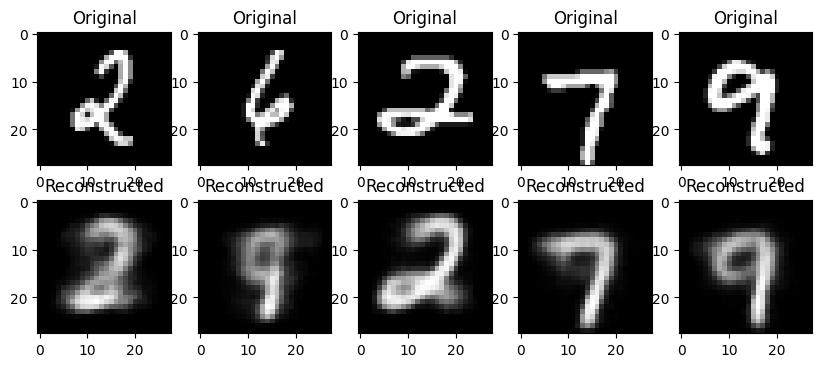

In [10]:
# kiểm tra mô hình
model.eval()
with torch.no_grad():
  data_iter = iter(val_loader)
  images, _ = next(data_iter)
  images = images.to(device)
  recon_images, _, _ = model(images)

  # Visualize the original and reconstructed images
  num_images_to_show = 5
  fig, axes = plt.subplots(2, num_images_to_show, figsize=(10, 4))
  for i in range(num_images_to_show):
    axes[0, i].imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[1, i].imshow(recon_images[i].cpu().squeeze().numpy(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
  plt.show()


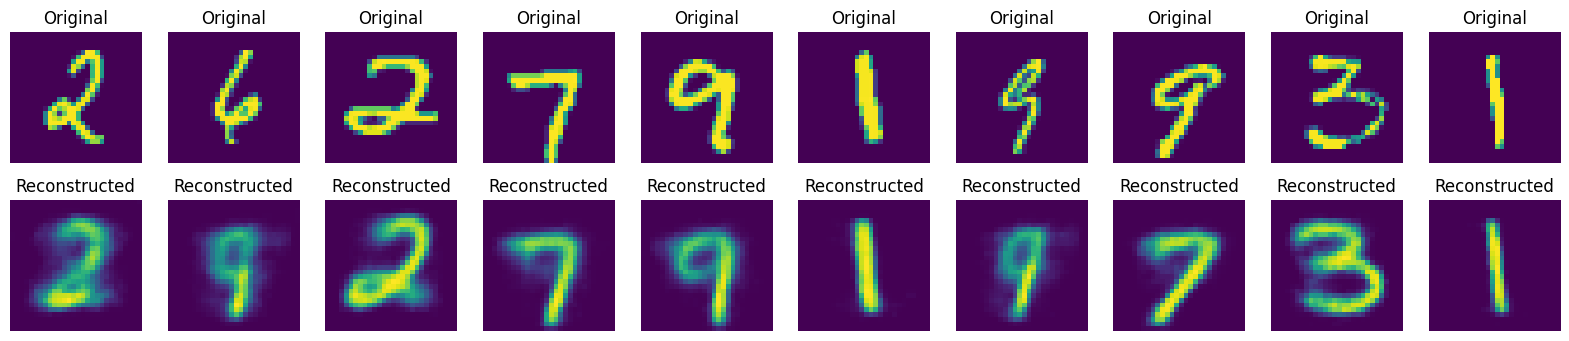

In [11]:
n = 10  #@param {type:"slider", min:1, max:20, step:1}
plt.figure(figsize=(20, 4))
for i in range(n):
  # Original image: (C,H,W) -> (H,W,C)
  orig = images[i].cpu().permute(1, 2, 0).numpy()
  recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(orig)
  plt.title("Original")
  plt.axis('off')

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(recon)
  plt.title("Reconstructed")
  plt.axis('off')

plt.show()


## Test

In [12]:
import torch
# cố định random
torch.manual_seed(0)

# Tạo một batch gồm 2 ma trận có kích thước 3, 28, 28 random bất kỳ
batch1 = torch.randn(2, 3, 4, 4)
print(batch1)

# Tạo một batch gồm 2 ma trận có kích thước 3, 28, 28 random bất kỳ khác
batch2 = torch.randn(2, 3, 4, 4)
print(batch2)

# Flatten các ma trận trong batch

recon_y_flat = batch1.view(batch1.size(0), -1)

y_flat = batch2.view(batch2.size(0), -1)

print(recon_y_flat)
print(y_flat)

tensor([[[[-1.1258e+00, -1.1524e+00, -2.5058e-01, -4.3388e-01],
          [ 8.4871e-01,  6.9201e-01, -3.1601e-01, -2.1152e+00],
          [ 3.2227e-01, -1.2633e+00,  3.4998e-01,  3.0813e-01],
          [ 1.1984e-01,  1.2377e+00,  1.1168e+00, -2.4728e-01]],

         [[-1.3527e+00, -1.6959e+00,  5.6665e-01,  7.9351e-01],
          [ 5.9884e-01, -1.5551e+00, -3.4136e-01,  1.8530e+00],
          [ 7.5019e-01, -5.8550e-01, -1.7340e-01,  1.8348e-01],
          [ 1.3894e+00,  1.5863e+00,  9.4630e-01, -8.4368e-01]],

         [[-6.1358e-01,  3.1593e-02, -4.9268e-01,  2.4841e-01],
          [ 4.3970e-01,  1.1241e-01,  6.4079e-01,  4.4116e-01],
          [-1.0231e-01,  7.9244e-01, -2.8967e-01,  5.2507e-02],
          [ 5.2286e-01,  2.3022e+00, -1.4689e+00, -1.5867e+00]]],


        [[[-6.7309e-01,  8.7283e-01,  1.0554e+00,  1.7784e-01],
          [-2.3034e-01, -3.9175e-01,  5.4329e-01, -3.9516e-01],
          [-4.4622e-01,  7.4402e-01,  1.5210e+00,  3.4105e+00],
          [-1.5312e+00, -1.2341e

In [13]:
from torch.nn import functional as F

# Tính toán hàm mất mát
mse_out = F.mse_loss(recon_y_flat, y_flat, reduction='mean')
print(mse_out)

tensor(2.0352)
